In [1]:
# download dataset
!wget -nc https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/yellow_tripdata_2019-06.csv 

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
# download June 2020 TLC Yellow Taxi Trip records
# Uncomment the next line, if working locally
!curl https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/yellow_tripdata_2019-06.csv 

^C


In [2]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import mean_squared_error

In [4]:
import time
import warnings
import gc, sys
warnings.filterwarnings('ignore')

In [5]:
# url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/yellow_tripdata_2019-06.csv "

In [6]:
df = pd.read_csv("yellow_tripdata_2019-06.csv")
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2019-06-01 00:55:13,2019-06-01 00:56:17,1,0.0,1,N,145,145,2,3.0,0.5,0.5,0.00,0.0,0.3,4.30,0.0
1,1,2019-06-01 00:06:31,2019-06-01 00:06:52,1,0.0,1,N,262,263,2,2.5,3.0,0.5,0.00,0.0,0.3,6.30,2.5
2,1,2019-06-01 00:17:05,2019-06-01 00:36:38,1,4.4,1,N,74,7,2,17.5,0.5,0.5,0.00,0.0,0.3,18.80,0.0
3,1,2019-06-01 00:59:02,2019-06-01 00:59:12,0,0.8,1,N,145,145,2,2.5,1.0,0.5,0.00,0.0,0.3,4.30,0.0
4,1,2019-06-01 00:03:25,2019-06-01 00:15:42,1,1.7,1,N,113,148,1,9.5,3.0,0.5,2.65,0.0,0.3,15.95,2.5


In [7]:
len(df.columns)

18

In [8]:
print(len(df))

6941024


In [9]:
df = df[df['tip_amount'] > 0]
df = df[(df['tip_amount'] <= df['fare_amount'])]
df = df[((df['fare_amount'] >=2) & (df['fare_amount'] < 200))]
clean_df = df.drop(['total_amount'], axis=1)

In [10]:
# release memory occupied by raw_data as we do not need it anymore
# we are dealing with a large dataset, thus we need to make sure we do not run out of memory
del df
gc.collect()

140

In [11]:
# print the number of trips left in the dataset
print("There are " + str(len(clean_df)) + " observations in the dataset.")
print("There are " + str(len(clean_df.columns)) + " variables in the dataset.")

There are 4776058 observations in the dataset.
There are 17 variables in the dataset.


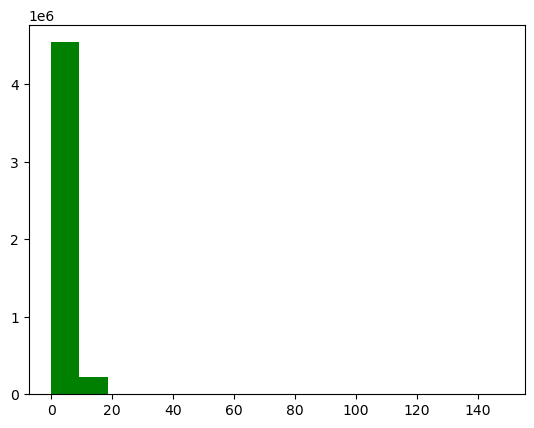

Minimum amount value is  0.01
Maximum amount value is  148.0
90% of the trips have a tip amount less or equal than  5.96


In [12]:
plt.hist(clean_df.tip_amount.values, 16, histtype='bar', facecolor='g')
plt.show()

print("Minimum amount value is ", np.min(clean_df.tip_amount.values))
print("Maximum amount value is ", np.max(clean_df.tip_amount.values))
print("90% of the trips have a tip amount less or equal than ", np.percentile(clean_df.tip_amount.values, 90))

# Preprocessing

In [13]:
clean_df['tpep_dropoff_datetime'] = pd.to_datetime(clean_df['tpep_dropoff_datetime'])
clean_df['tpep_pickup_datetime'] = pd.to_datetime(clean_df['tpep_pickup_datetime'])

In [14]:
clean_df['pickup_hour'] = clean_df['tpep_pickup_datetime'].dt.hour
clean_df['dropoff_hour'] = clean_df['tpep_dropoff_datetime'].dt.hour

In [15]:
clean_df['pickup_day'] = clean_df['tpep_pickup_datetime'].dt.weekday
clean_df['dropoff_day'] = clean_df['tpep_dropoff_datetime'].dt.weekday

In [16]:
clean_df['trip_time'] = (clean_df['tpep_dropoff_datetime'] - clean_df['tpep_pickup_datetime']).dt.total_seconds()

In [17]:
first_n_rows = 200000
clean_df = clean_df.head(first_n_rows)

In [18]:
# drop the pickup and dropoff datetimes
clean_df = clean_df.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1)

# some features are categorical, we need to encode them
# to encode them we use one-hot encoding from the Pandas package
get_dummy_col = ["VendorID","RatecodeID","store_and_fwd_flag","PULocationID", "DOLocationID","payment_type", "pickup_hour", "dropoff_hour", "pickup_day", "dropoff_day"]
proc_data = pd.get_dummies(clean_df, columns = get_dummy_col)
del clean_df
gc.collect()

3754

In [19]:
# extract the labels from the dataframe
y = proc_data[['tip_amount']].values.astype('float32')

# drop the target variable from the feature matrix
proc_data = proc_data.drop(['tip_amount'], axis=1)

# get the feature matrix used for training
X = proc_data.values

# normalize the feature matrix
X = normalize(X, axis=1, norm='l1', copy=False)

# print the shape of the features matrix and the labels vector
print('X.shape=', X.shape, 'y.shape=', y.shape)

X.shape= (200000, 517) y.shape= (200000, 1)


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [21]:
from sklearn.tree import DecisionTreeRegressor
sklearn_dt = DecisionTreeRegressor(max_depth=8, random_state=35)
sklearn_dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=8, random_state=35)

In [22]:
sklearn_pred = sklearn_dt.predict(X_test)

# evaluate mean squared error on the test dataset
sklearn_mse = mean_squared_error(y_test, sklearn_pred)
print('[Scikit-Learn] MSE score : {0:.3f}'.format(sklearn_mse))

[Scikit-Learn] MSE score : 1.636


In [23]:
from snapml import DecisionTreeRegressor

# in contrast to sklearn's Decision Tree, Snap ML offers multi-threaded CPU/GPU training 
# to use the GPU, one needs to set the use_gpu parameter to True
# snapml_dt = DecisionTreeRegressor(max_depth=4, random_state=45, use_gpu=True)

snapml_dt = DecisionTreeRegressor(max_depth=8, random_state=45, n_jobs=4)
snapml_dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=8, n_jobs=4, random_state=45)

In [24]:
snapml_pred = snapml_dt.predict(X_test)

# evaluate mean squared error on the test dataset
snapml_mse = mean_squared_error(y_test, snapml_pred)
print('[Snap ML] MSE score : {0:.3f}'.format(snapml_mse))

[Snap ML] MSE score : 1.655
